In [25]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

In [5]:
db=mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='pass@123',
    database='ecommerce'
)
cur = db.cursor()

# List all unique cities where customers are located.

In [90]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [26]:
query1="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query1)
data=cur.fetchall()
data[0][0]

45101

Find the total sales per category.

In [92]:
query2="""select upper(p.product_category) as category,round(sum(py.payment_value),2) as sales
from products p 
join order_items oi on p.product_id=oi.product_id
join payments py on oi.order_id=py.order_id
group by p.product_category"""
cur.execute(query2)
data=cur.fetchall()
df =pd.DataFrame(data,columns=["category","sales"])
df.head()

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments.

In [48]:
query4="""select (sum(
case
     when payment_installments >1 then 1 
else 0
end
))/count(*)*100 from payments"""
cur.execute(query4)
data=cur.fetchall()
"pecentalte of sales on installments",data[0][0]

('pecentalte of sales on installments', Decimal('49.4176'))

# Count the number of customers from each state.

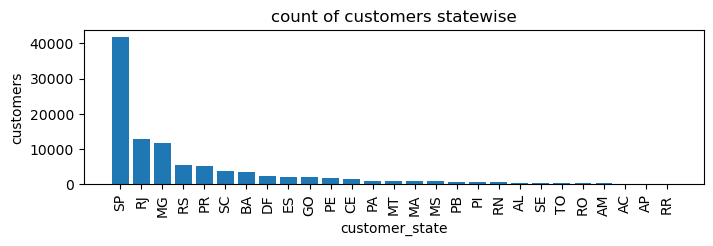

In [148]:
query5="""select  customer_state, count(customer_id) as customers from customers  group by customer_state"""
cur.execute(query5)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_state","customers"])
df=df.sort_values(by="customers",ascending=False)
plt.figure(figsize=(8,2))
plt.bar(df["customer_state"],df["customers"])
plt.xticks(rotation=90)
plt.xlabel("customer_state")
plt.ylabel("customers")
plt.title("count of customers statewise")
plt.show()

# Calculate the number of orders per month in 2018.

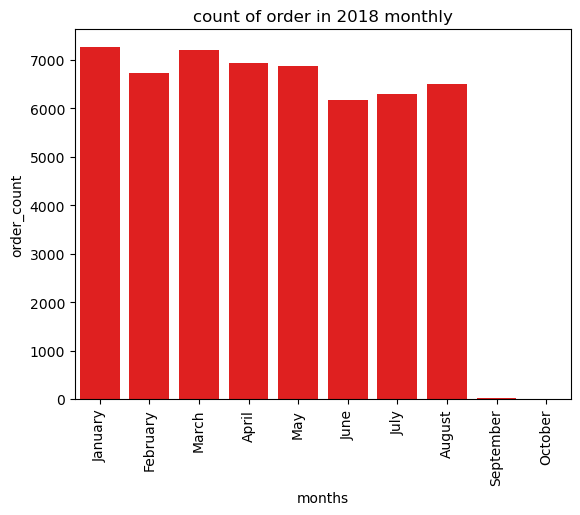

In [156]:
query6=""" select monthname(order_purchase_timestamp) months,count(order_id) as order_count from orders where year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp)"""
cur.execute(query6)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
#df
o=["January","February","March","April","May","June","July","August","September","October"]
sns.barplot(x=df["months"],y=df["order_count"],order=o,color="red")
#plt.figure(figsize=(8,3))
plt.xticks(rotation=90)
plt.title("count of order in 2018 monthly")
plt.show() 


# Find the average number of products per order, grouped by customer city.

In [193]:

query7="""with abc as (select orders.order_id, orders.customer_id,count(order_items.order_id) as oc
from orders 
join order_items on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city as city ,round(avg(abc.oc),2) as avg_order
from customers 
join abc on customers.customer_id=abc.customer_id
group by customers.customer_city
order by avg_order desc"""

cur.execute(query7)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["city","avg_order"])
df.head()

,city,avg_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# total revenue contributed by each product category.

In [7]:
query8="""select products.product_category,
sum(payments.payment_value)/(select sum(payment_value) from payments)*100 as per_revenue
from products
join order_items on products.product_id=order_items.product_id
join  payments on order_items.order_id=payments.order_id
group by products.product_category
order by per_revenue desc"""

cur.execute(query8)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","revenue"])
df.head()

,category,revenue
0,bed table bath,10.697529
1,HEALTH BEAUTY,10.352841
2,computer accessories,9.902824
3,Furniture Decoration,8.933649
4,Watches present,8.927654


#  Identify the correlation between avg product price and the number of times a product purchase categorywise has been purchased.

In [33]:
import numpy
query9="""select p.product_category,count(ot.product_id),avg(ot.price)
from order_items ot 
join products p on ot.product_id=p.product_id
group by p.product_category"""

cur.execute(query9)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["category","count","avg_price"])
arr1=df["count"]
arr2=df["avg_price"]

np1=numpy.corrcoef([arr1,arr2])
print("correlation between count of purchase and average price",np1[0][1]) 

correlation between count of purchase and average price -0.10631552237549534


# Calculate the total revenue generated by each seller, and rank them by revenue.

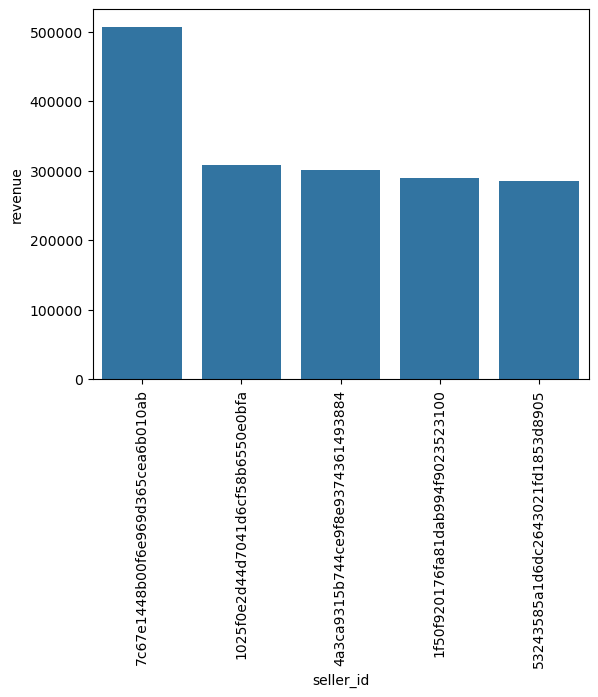

In [43]:
query10="""select * ,dense_rank() over(order by total desc) as rnk from (select ot.seller_id,round(sum(py.payment_value)) as total
from order_items ot
join payments py on ot.order_id=py.order_id
group by ot.seller_id) as a"""

cur.execute(query10)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x= "seller_id",y = "revenue", data = df)
plt.xticks(rotation=90)
plt.show()            
            

# Calculate the moving average of order values for each customer over their order history.

In [52]:
query11="""select customer_id, order_purchase_timestamp,payment,
avg (payment) over( partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from (select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments 
join orders on payments.order_id=orders.order_id) as a"""

cur.execute(query11)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["customer_id","timestamp","payment","moving_avg"])
df.head(10)

,customer_id,timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# Calculate the cumulative sales per month for each year.

In [59]:
query12="""select yr , mont ,payment , sum(payment) over( order by yr, mont) as cumulative_sum from
(select year(o.order_purchase_timestamp) as yr, month(o.order_purchase_timestamp) as mont, round(sum( p.payment_value)) as payment
from orders o
join payments p on o.order_id=p.order_id
group by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp) 
order by yr,mont) as a"""

cur.execute(query12)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["year","month","payment","cumulative total"])
df.head(10)

,year,month,payment,cumulative total
0,2016,9,252.0,252.0
1,2016,10,59090.0,59342.0
2,2016,12,20.0,59362.0
3,2017,1,138488.0,197850.0
4,2017,2,291908.0,489758.0
5,2017,3,449864.0,939622.0
6,2017,4,417788.0,1357410.0
7,2017,5,592919.0,1950329.0
8,2017,6,511276.0,2461605.0
9,2017,7,592383.0,3053988.0
